
**Goal**: Personalize Stable Diffusion on a small dataset using LoRA (Low-Rank Adaptation).

---

##  Why LoRA?

**Problem with Full Fine-tuning**:
-  Stable Diffusion has ~900M parameters
-  Full fine-tuning requires days on expensive GPUs
-  Each personalized model = ~4-5GB storage

**LoRA Solution**:
-  Train only **0.5-1% of parameters** (~5-10MB)
-  Training time: **5-10 minutes** on Colab T4
-  Can stack multiple LoRA adapters on the same base model

### Mathematical Intuition

Original layer: `Y = WX` (W is frozen, e.g., 1024×1024 = 1M params)

LoRA adds low-rank matrices: `Y = WX + B·A·X`
- B: 1024×8 (8K params)
- A: 8×1024 (8K params)
- Total LoRA params: **16K** instead of 1M!

### Which Layers to Adapt?

We target **cross-attention layers** in the UNet because they:
- Control text-to-image alignment
- Learn which words map to which visual features
- Are most effective for learning new concepts/styles


---

## 1️ Setup & Installation

In [1]:
# Install required packages
!pip install -q diffusers transformers accelerate peft torch torchvision datasets bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.1 MB/s eta 0:00:00


In [2]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model, PeftModel
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
import requests
from io import BytesIO

print(" Imports successful!")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


 Imports successful!


In [3]:
# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print(f" GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print(" No GPU detected. Training will be VERY slow!")

# Create directories
os.makedirs("../data/sample_images", exist_ok=True)
os.makedirs("../outputs", exist_ok=True)
os.makedirs("./lora_weights", exist_ok=True)
print(" Directories ready")

 GPU: Tesla T4
   VRAM: 15.83 GB
 Directories ready


---

## 2️ Prepare Training Dataset

For this demo, we'll download sample images of **dogs** from public URLs.

**In practice**: You would use your own 10-20 images of a specific subject/style.

In [4]:
# Sample image URLs (replace with your own images)
# Using placeholder images from Unsplash (dog photos)
sample_image_urls = [
    "https://images.unsplash.com/photo-1543466835-00a7907e9de1?w=512&h=512&fit=crop",
    "https://images.unsplash.com/photo-1552053831-71594a27632d?w=512&h=512&fit=crop",
    "https://images.unsplash.com/photo-1583511655857-d19b40a7a54e?w=512&h=512&fit=crop",
    "https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=512&h=512&fit=crop",
    "https://images.unsplash.com/photo-1580489944761-15a19d654956?w=512&h=512&fit=crop",
    "https://images.unsplash.com/photo-1561037404-61cd46aa615b?w=512&h=512&fit=crop",
    "https://images.unsplash.com/photo-1529429617124-95b109e86bb8?w=512&h=512&fit=crop",
    "https://images.unsplash.com/photo-1558788353-f76d92427f16?w=512&h=512&fit=crop",
    "https://images.unsplash.com/photo-1548199973-03cce0bbc87b?w=512&h=512&fit=crop",
    "https://images.unsplash.com/photo-1537151608828-ea2b11777ee8?w=512&h=512&fit=crop",
]

print("Downloading sample training images...")
for idx, url in enumerate(sample_image_urls):
    try:
        response = requests.get(url, timeout=10)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img.save(f"../data/sample_images/dog_{idx:02d}.jpg")
        print(f"  ✓ Downloaded image {idx+1}/{len(sample_image_urls)}")
    except Exception as e:
        print(f"  ✗ Failed to download image {idx+1}: {e}")

print("\n Training images ready!")

  ✓ Downloaded image 1/10
  ✓ Downloaded image 2/10
  ✓ Downloaded image 3/10
  ✓ Downloaded image 4/10
  ✓ Downloaded image 5/10
  ✓ Downloaded image 6/10
  ✓ Downloaded image 7/10
  ✓ Downloaded image 8/10
  ✓ Downloaded image 9/10
  ✓ Downloaded image 10/10

 Training images ready!


Found 10 training images



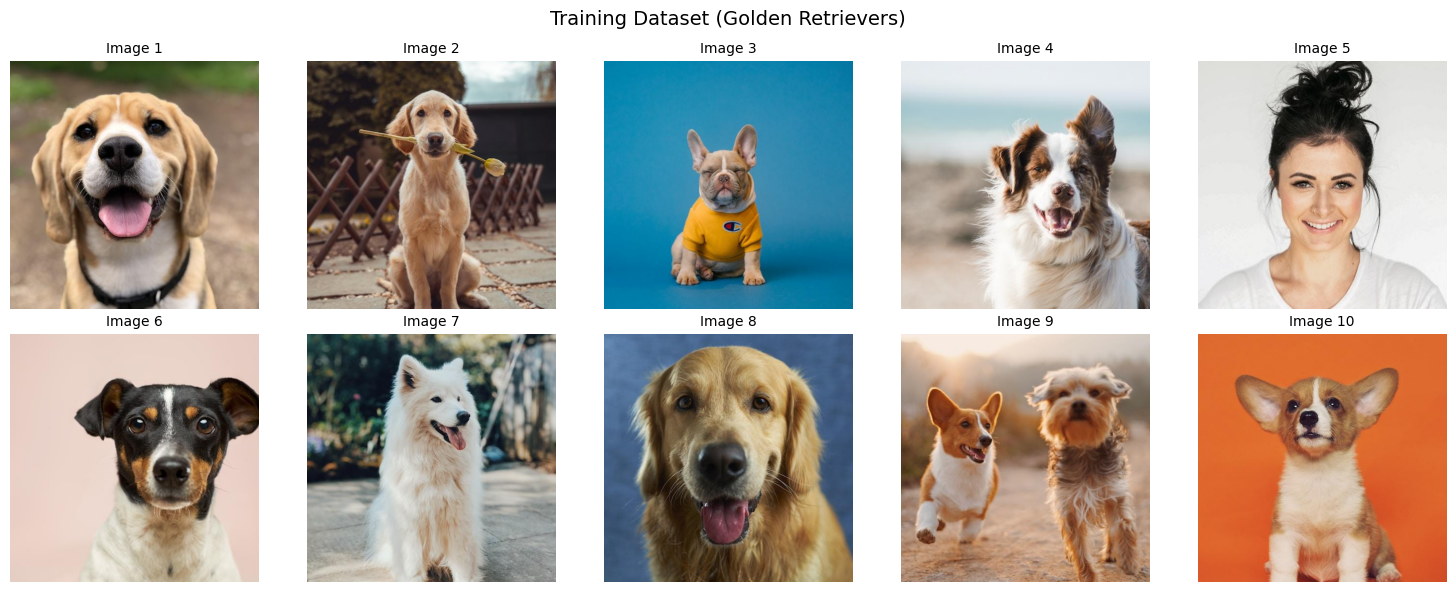

In [5]:
# Visualize training images
import glob

image_paths = sorted(glob.glob("../data/sample_images/*.jpg"))
print(f"Found {len(image_paths)} training images\n")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, img_path in enumerate(image_paths[:10]):
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"Image {idx+1}", fontsize=10)

plt.suptitle("Training Dataset (Golden Retrievers)", fontsize=14)
plt.tight_layout()
plt.show()

---

## 3️ Create Dataset & DataLoader

In [6]:
class DreamBoothDataset(Dataset):
    """
    Simple dataset for LoRA fine-tuning.
    Each image is paired with a text prompt containing the instance token.
    """
    def __init__(self, image_paths, instance_prompt, size=512):
        self.image_paths = image_paths
        self.instance_prompt = instance_prompt

        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),  # Normalize to [-1, 1]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)

        return {
            "images": image,
            "prompts": self.instance_prompt,
        }

# Instance prompt - the special token for your subject
instance_prompt = "a photo of sks dog"  # 'sks' is a rare token identifier

# Create dataset
train_dataset = DreamBoothDataset(
    image_paths=image_paths,
    instance_prompt=instance_prompt,
    size=512,
)

# Create dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,  # Small batch for limited VRAM
    shuffle=True,
)

print(f" Dataset ready: {len(train_dataset)} images")
print(f"   Instance prompt: '{instance_prompt}'")

✅ Dataset ready: 10 images
   Instance prompt: 'a photo of sks dog'


###  What is 'sks'?

**Instance token** (`sks`) is a rare/unique token in CLIP's vocabulary:
- Acts as a placeholder for your specific subject
- Prevents overfitting to common words like "dog"
- After training, "sks dog" will generate YOUR style of dogs

**Alternative tokens**: `v1`, `xyz`, `rare_token` (avoid common words!)

---

## 4️ Load Model Components & Configure LoRA

In [7]:
model_id = "runwayml/stable-diffusion-v1-5"

print("Loading model components...\n")

# Load components separately for training
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")

# Freeze VAE and text encoder (we only train UNet)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

# Move to GPU
vae = vae.to(device, dtype=torch.float16)
text_encoder = text_encoder.to(device, dtype=torch.float16)
unet = unet.to(device, dtype=torch.float16)

print(" Base model components loaded")

Loading model components...



config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: runwayml/stable-diffusion-v1-5
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

✅ Base model components loaded


In [8]:
# Configure LoRA
lora_config = LoraConfig(
    r=8,  # Rank of LoRA matrices (higher = more capacity, but more params)
    lora_alpha=16,  # Scaling factor (typically 2*r)
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],  # Attention projection layers
    lora_dropout=0.0,  # No dropout for small datasets
)

# Apply LoRA to UNet
unet = get_peft_model(unet, lora_config)

print(" LoRA configured!\n")
unet.print_trainable_parameters()

✅ LoRA configured!

trainable params: 1,594,368 || all params: 861,115,332 || trainable%: 0.1852


###  Understanding Target Modules

We target **cross-attention** query, key, value, and output projections:

| Module | Purpose | Why LoRA? |
|--------|---------|----------|
| `to_q` | Query projection | Controls what image features to attend to |
| `to_k` | Key projection | Controls how text tokens align with image |
| `to_v` | Value projection | Controls what information to extract |
| `to_out.0` | Output projection | Combines attended information |

These layers are **most effective** for learning new visual concepts!

---

## 5️ Training Loop

In [9]:
from diffusers import DDPMScheduler

# Training hyperparameters
learning_rate = 1e-4
num_epochs = 20  # ~200 steps with 10 images
gradient_accumulation_steps = 1

# Optimizer
optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=learning_rate,
)

# Noise scheduler for training (different from inference)
noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

print(f"Training Configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Batch size: 1")
print(f"  Total steps: ~{num_epochs * len(train_dataloader)}\n")

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

Training Configuration:
  Epochs: 20
  Learning rate: 0.0001
  Batch size: 1
  Total steps: ~200



In [10]:
# Training loop
unet.train()
progress_bar = tqdm(range(num_epochs * len(train_dataloader)), desc="Training LoRA")

losses = []

for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        # Get images and prompts
        images = batch["images"].to(device, dtype=torch.float16)
        prompts = batch["prompts"]

        # Encode images to latent space
        with torch.no_grad():
            latents = vae.encode(images).latent_dist.sample()
            latents = latents * vae.config.scaling_factor  # Scale latents

        # Sample random timesteps
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],),
            device=device
        ).long()

        # Add noise to latents (forward diffusion)
        noise = torch.randn_like(latents)
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Encode text prompts
        with torch.no_grad():
            text_inputs = tokenizer(
                prompts,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]

        # Predict noise with UNet (this is what we're training!)
        noise_pred = unet(noisy_latents, timesteps, text_embeddings).sample

        # Compute loss (MSE between predicted and actual noise)
        loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Logging
        losses.append(loss.item())
        progress_bar.update(1)
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

print("\n Training complete!")

Training LoRA:   0%|          | 0/200 [00:00<?, ?it/s]


✅ Training complete!


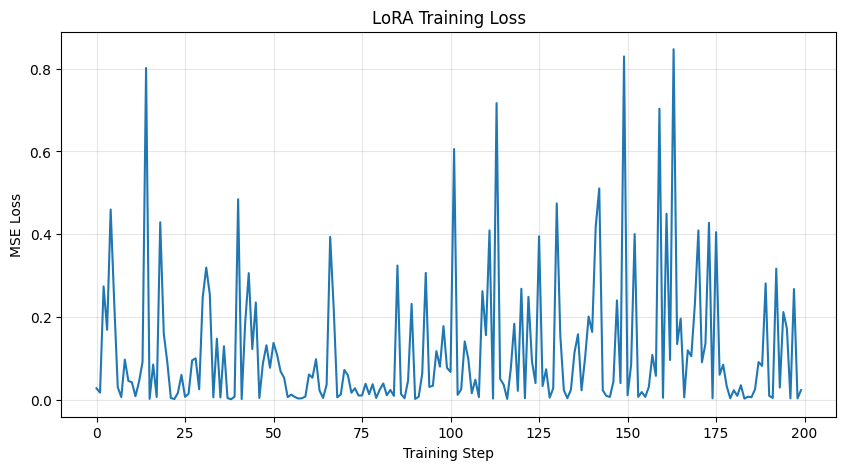

Final loss: 0.0242
Average loss (last 20 steps): 0.0810


In [11]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("MSE Loss")
plt.title("LoRA Training Loss")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses[-1]:.4f}")
print(f"Average loss (last 20 steps): {sum(losses[-20:]) / len(losses[-20:]):.4f}")

---

## 6️ Save LoRA Weights

In [12]:
# Save only LoRA weights (tiny file!)
unet.save_pretrained("./lora_weights")

# Check file size
import os
lora_size = sum(os.path.getsize(os.path.join("./lora_weights", f))
                for f in os.listdir("./lora_weights") if os.path.isfile(os.path.join("./lora_weights", f)))

print(f" LoRA weights saved!")
print(f"   Size: {lora_size / 1e6:.2f} MB (vs ~4GB for full model)")
print(f"   Location: ./lora_weights/")

✅ LoRA weights saved!
   Size: 6.42 MB (vs ~4GB for full model)
   Location: ./lora_weights/


---

## 7️ Inference with LoRA Adapter

In [13]:
# Load base pipeline
print("Loading base Stable Diffusion pipeline...")
pipe_lora = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
)

# Load LoRA weights into the UNet
pipe_lora.unet = PeftModel.from_pretrained(
    pipe_lora.unet,
    "./lora_weights",
)

pipe_lora = pipe_lora.to(device)
pipe_lora.enable_attention_slicing()
pipe_lora.scheduler = DPMSolverMultistepScheduler.from_config(pipe_lora.scheduler.config)

print(" Pipeline with LoRA ready!")

Loading base Stable Diffusion pipeline...


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its resul

✅ Pipeline with LoRA ready!


Generating: a photo of sks dog wearing sunglasses at the beach


  0%|          | 0/25 [00:00<?, ?it/s]

Generating: a photo of sks dog in a spaceship, sci-fi


  0%|          | 0/25 [00:00<?, ?it/s]

Generating: a photo of sks dog as a superhero, comic book style


  0%|          | 0/25 [00:00<?, ?it/s]

Generating: a photo of sks dog playing in snow, winter wonderland


  0%|          | 0/25 [00:00<?, ?it/s]

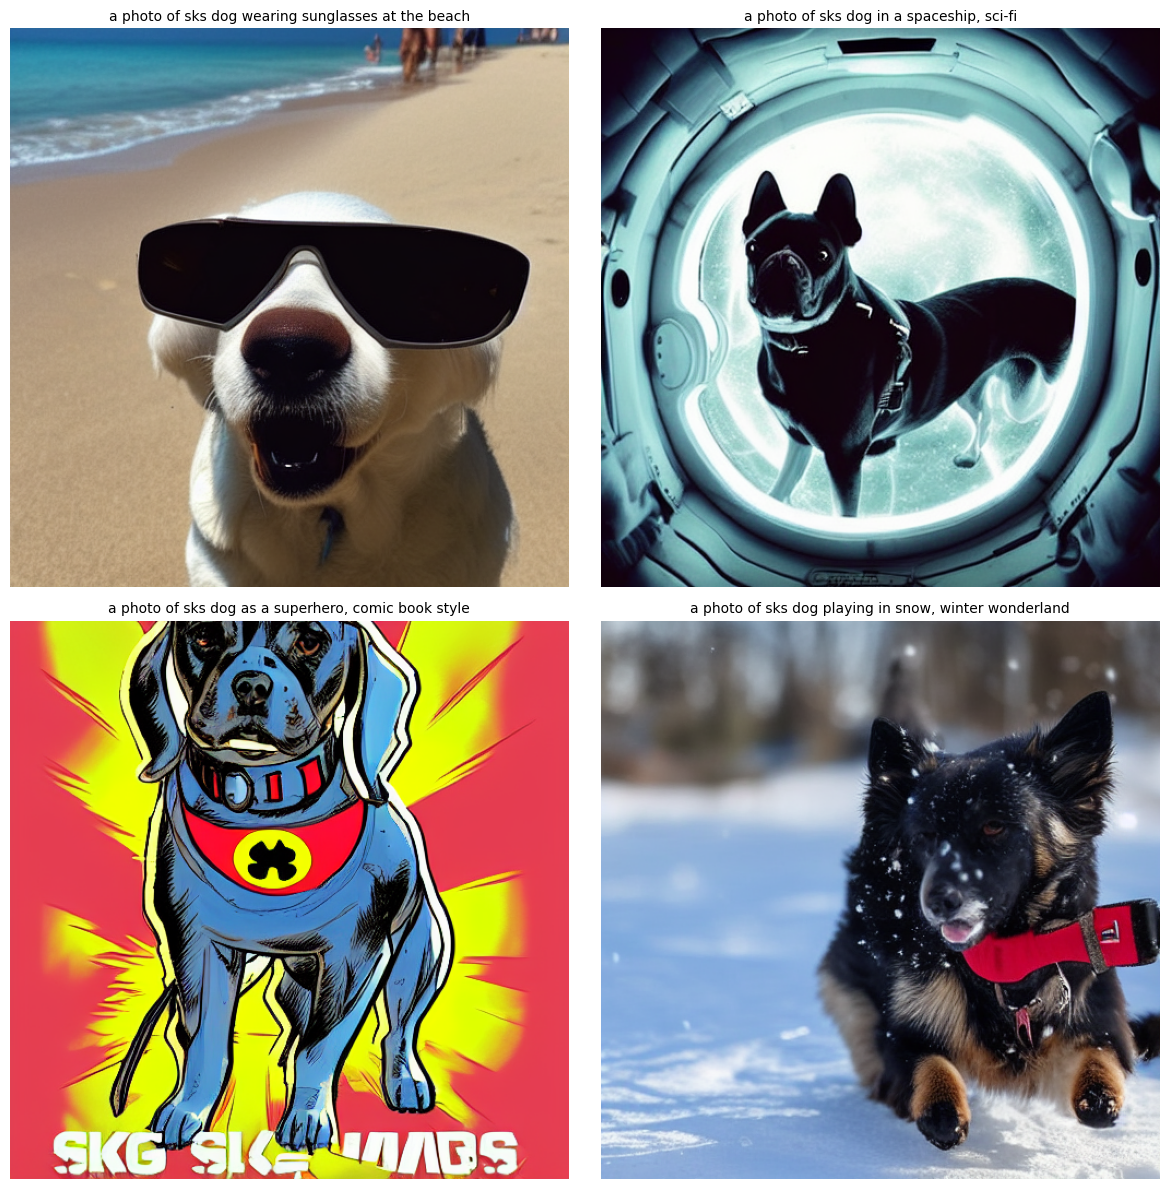


✅ LoRA-personalized images generated!


In [14]:
# Generate images with the personalized model
prompts_to_test = [
    "a photo of sks dog wearing sunglasses at the beach",
    "a photo of sks dog in a spaceship, sci-fi",
    "a photo of sks dog as a superhero, comic book style",
    "a photo of sks dog playing in snow, winter wonderland",
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, prompt in enumerate(prompts_to_test):
    print(f"Generating: {prompt}")

    with torch.autocast(device):
        image = pipe_lora(
            prompt,
            num_inference_steps=25,
            guidance_scale=7.5,
        ).images[0]

    axes[idx].imshow(image)
    axes[idx].axis('off')
    axes[idx].set_title(prompt, fontsize=10, wrap=True)

    image.save(f"../outputs/lora_result_{idx+1}.png")

plt.tight_layout()
plt.show()

print("\n LoRA-personalized images generated!")

---

## 8️ Comparison: Base vs. LoRA

In [15]:
# Load base model (without LoRA)
pipe_base = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
).to(device)
pipe_base.enable_attention_slicing()
pipe_base.scheduler = DPMSolverMultistepScheduler.from_config(pipe_base.scheduler.config)

print(" Base model loaded for comparison")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its resul

✅ Base model loaded for comparison


Generating with BASE model: a photo of sks dog in a tuxedo, professional portrait


  0%|          | 0/25 [00:00<?, ?it/s]

Generating with LORA model: a photo of sks dog in a tuxedo, professional portrait


  0%|          | 0/25 [00:00<?, ?it/s]

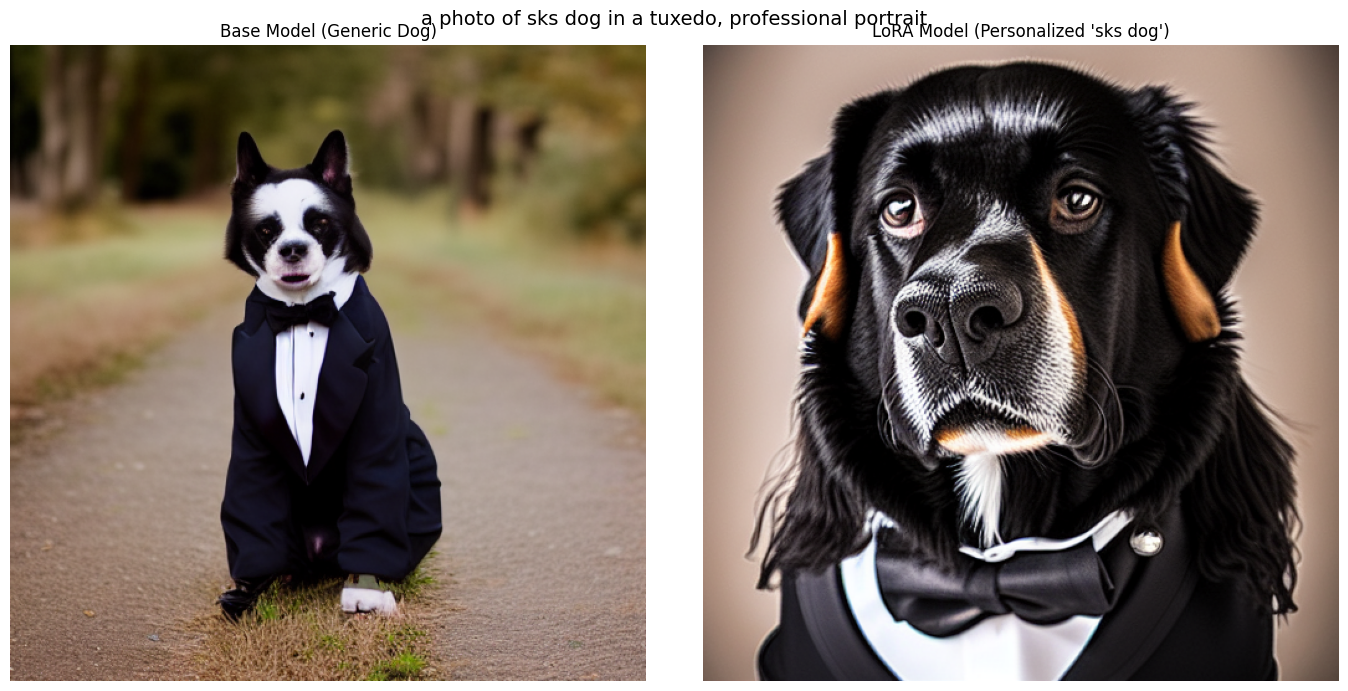


✅ Notice: LoRA model captures the specific style/appearance from training data!


In [16]:
# Compare base vs LoRA
comparison_prompt = "a photo of sks dog in a tuxedo, professional portrait"

print(f"Generating with BASE model: {comparison_prompt}")
with torch.autocast(device):
    img_base = pipe_base(comparison_prompt, num_inference_steps=25, guidance_scale=7.5).images[0]

print(f"Generating with LORA model: {comparison_prompt}")
with torch.autocast(device):
    img_lora = pipe_lora(comparison_prompt, num_inference_steps=25, guidance_scale=7.5).images[0]

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(img_base)
axes[0].axis('off')
axes[0].set_title("Base Model (Generic Dog)", fontsize=12)

axes[1].imshow(img_lora)
axes[1].axis('off')
axes[1].set_title("LoRA Model (Personalized 'sks dog')", fontsize=12)

plt.suptitle(comparison_prompt, fontsize=14)
plt.tight_layout()
plt.show()

print("\n Notice: LoRA model captures the specific style/appearance from training data!")